# Twitter Sentiment Analysis

Kaggle notebook that showcases a Twitter sentiment analysis project using Python and various machine learning and natural language processing (NLP) libraries.

The notebook begins with a brief explanation of sentiment analysis and its potential applications in various industries such as marketing, finance, and politics. The author then proceeds to describe the dataset used in the project, which contains around 1.6 million tweets collected using the Twitter API during the 2016 US Presidential Election campaign.

The next section of the notebook is dedicated to data preprocessing, which includes cleaning the text data, removing stop words, and tokenizing the tweets. The author also performs some exploratory data analysis (EDA) to gain insights into the dataset, such as the distribution of sentiment labels (positive, negative, or neutral) and the most frequent words used in each sentiment category.

After the data preprocessing and EDA, the author proceeds to train several machine learning models to classify the sentiment of the tweets. 

Finally, the notebook concludes with a discussion on the limitations and potential improvements of the project. The author suggests that future work could involve improving the accuracy of the sentiment analysis by incorporating domain-specific knowledge and using more advanced NLP techniques such as deep learning.

In [ ]:
!pip install -q gensim
!pip install -q keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

nltk.download('stopwords')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 4
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

path = '/content/drive/MyDrive/BTC/SENTIMETER'

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [ ]:
df = pd.read_parquet(f'{path}/labelled.parquet')
#df['target'] = np.where(df['target']==4,1,df['target']) #forzo la positive class a 1
df

,text,target,id,Datetime,username
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_
1,is upset that he can't update his Facebook by ...,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton
2,@Kenichan I dived many times for the ball. Man...,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus
3,my whole body feels itchy and like its on fire,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF
4,"@nationwideclass no, it's not behaving at all....",0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli
...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz


In [ ]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [ ]:
df.head(5)

,text,target,id,Datetime,username
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_
1,is upset that he can't update his Facebook by ...,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton
2,@Kenichan I dived many times for the ball. Man...,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus
3,my whole body feels itchy and like its on fire,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF
4,"@nationwideclass no, it's not behaving at all....",0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 422 ms, sys: 25 ms, total: 447 ms
Wall time: 435 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

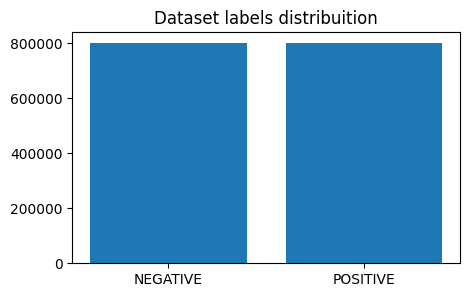

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(5,3))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 8s, sys: 603 ms, total: 1min 9s
Wall time: 1min 32s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 6.54 s, sys: 1.4 s, total: 7.93 s
Wall time: 8.02 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec( 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 17min 18s, sys: 5.47 s, total: 17min 24s
Wall time: 10min 47s


(263126460, 295270528)

In [ ]:
w2v_model.wv.most_similar("love") 

[('loves', 0.6682484745979309),
 ('adore', 0.6669764518737793),
 ('luv', 0.6583859324455261),
 ('looove', 0.6344553232192993),
 ('loooove', 0.607738733291626),
 ('loved', 0.6059436202049255),
 ('amazing', 0.5930517315864563),
 ('loove', 0.5472488403320312),
 ('loveee', 0.5418241620063782),
 ('loveeee', 0.5417048335075378)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 24.5 s, sys: 155 ms, total: 24.7 s
Wall time: 24.9 s


In [ ]:
%%time
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 30.2 s, sys: 1.7 s, total: 31.9 s
Wall time: 32.2 s


### Label Encoder 

the LabelEncoder class from the sklearn.preprocessing module is used to convert the categorical target variables in df_train and df_test into numeric labels.

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In natural language processing and deep learning, an embedding layer is a layer in a neural network that learns to represent words or other features as dense, continuous vectors (embeddings). These vectors are typically of lower dimensionality than the one-hot encoded vectors that represent words as sparse, high-dimensional vectors.

The embedding layer takes as input a sequence of integer-encoded words (e.g., [3, 25, 12, 7]), and outputs a sequence of dense embeddings (e.g., [-0.12, 0.45, 0.23, -0.15]) that represent the meaning of each word in the context of the sentence. The embeddings are learned during training of the neural network using techniques such as Word2Vec, GloVe, or FastText.

The benefit of using an embedding layer is that it allows the neural network to learn meaningful representations of words that capture their semantic relationships. This can improve the performance of the network on downstream tasks such as sentiment analysis, named entity recognition, or machine translation.

The code loops through each word in the vocabulary (tokenizer.word_index.items()) and checks if the word is present in the trained Word2Vec model (word in w2v_model.wv). If the word is present, the code retrieves the corresponding embedding vector from the Word2Vec model (w2v_model.wv[word]).

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        # Check if the size of the embedding vector matches W2V_SIZE
        if len(w2v_model.wv[word]) == W2V_SIZE:
            embedding_matrix[i] = w2v_model.wv[word]
        else:
            # Handle the case where the size of the embedding vector is different
            print(f"Warning: Skipping {word} as its embedding vector size is {len(w2v_model.wv[word])} instead of {W2V_SIZE}")
print(embedding_matrix.shape)

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

 Embedding() is a layer that learns a mapping between integer-encoded words in the vocabulary and dense vectors of fixed size, often called embeddings. The Embedding() layer takes several arguments, including:

vocab_size: the size of the vocabulary (i.e., the number of distinct words)
W2V_SIZE: the dimensionality of the embedding space (i.e., the number of dimensions in the embedding vectors)

weights: an optional parameter that allows you to specify the initial weights for the embedding layer. In this case, weights is set to embedding_matrix, which is a numpy array that contains the pre-trained word embeddings (in this case, Word2Vec embeddings).

input_length: the length of each input sequence (i.e., the number of words in each sentence)

trainable: a boolean flag that indicates whether or not the embedding weights should be trainable during training. In this case, trainable is set to False, which means that the pre-trained embeddings will not be updated during training.

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples

Epoch 1/8
1152000/1152000 [==============================] - 1044s 906us/step - loss: 0.5077 - acc: 0.7477 - val_loss: 0.4647 - val_acc: 0.7793

Epoch 2/8
1152000/1152000 [==============================] - 1042s 904us/step - loss: 0.4814 - acc: 0.7659 - val_loss: 0.4591 - val_acc: 0.7830

Epoch 3/8
1152000/1152000 [==============================] - 1041s 904us/step - loss: 0.4743 - acc: 0.7703 - val_loss: 0.4559 - val_acc: 0.7858


Epoch 4/8
1152000/1152000 [==============================] - 1049s 911us/step - loss: 0.4699 - acc: 0.7732 - val_loss: 0.4528 - val_acc: 0.7868

Epoch 5/8
1152000/1152000 [==============================] - 1043s 906us/step - loss: 0.4675 - acc: 0.7745 - val_loss: 0.4502 - val_acc: 0.7875

Epoch 6/8
1152000/1152000 [==============================] - 1048s 910us/step - loss: 0.4657 - acc: 0.7763 - val_loss: 0.4501 - val_acc: 0.7890

Epoch 7/8
1152000/1152000 [==============================] - 1045s 907us/step - loss: 0.4638 - acc: 0.7770 - val_loss: 0.4487 - val_acc: 0.7889

Epoch 8/8
1152000/1152000 [==============================] - 1041s 904us/step - loss: 0.4632 - acc: 0.7774 - val_loss: 0.4460 - val_acc: 0.7899

CPU times: user 2h 49min 19s, sys: 18min 24s, total: 3h 7min 44s
Wall time: 2h 19min 14s

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

ACCURACY: 0.791134375

LOSS: 0.4442952796936035


In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

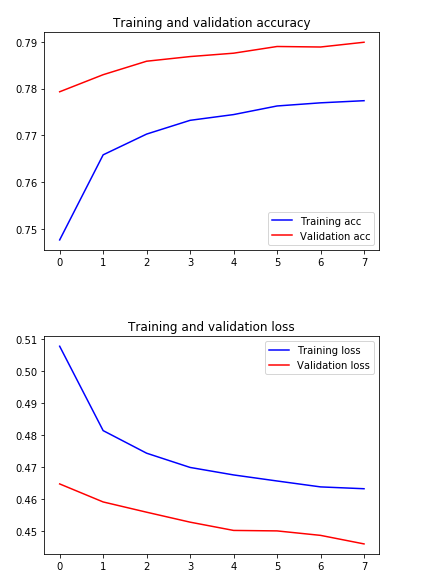

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'label': 'POSITIVE',

 'score': 0.9656286239624023,
 
 'elapsed_time': 0.4439425468444824}

In [ ]:
predict("I hate the rain")

{'label': 'NEGATIVE',

 'score': 0.010753681883215904,
 
 'elapsed_time': 0.26644086837768555}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

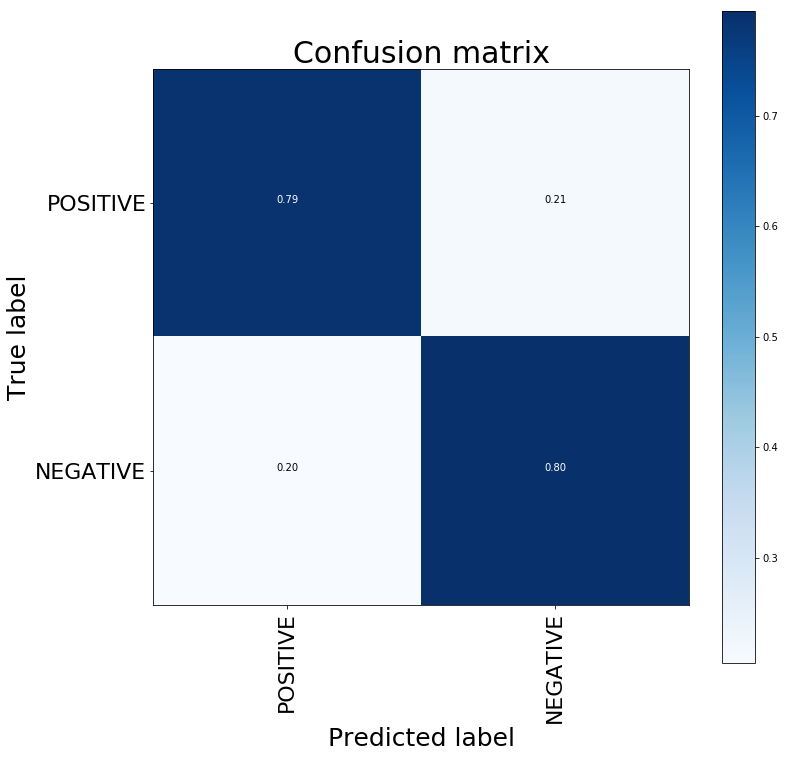

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

 precision    recall  f1-score   support


    NEGATIVE       0.79      0.79      0.79    159494

    POSITIVE       0.79      0.80      0.79    160506


   micro avg       0.79      0.79      0.79    320000

   macro avg       0.79      0.79      0.79    320000
   
weighted avg       0.79      0.79      0.79    320000

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.791134375

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)